## Motivation

- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?

This dataset provides a detailed look at shooting incidents in New York from 2006 to 2024, revealing trends and details about these events. It is an important tool for understanding city crime and safety over almost twenty years.

#### Dataset Attributes
 - __Incident Date:__ Captures the exact date each shooting occurred, providing a timeline for analysis.
 - __Borough:__ Indicates the specific borough within New York where the incident took place, crucial for geographic analysis.
 - __Incident Time:__ The time at which the incident occurred, valuable for identifying patterns related to time of day or night.
 - __Victim Count:__ Records the number of individuals impacted in each incident, which helps in understanding the severity.
 - __Incident Type:__ Describes the nature of the incident, such as robbery or altercation, offering insights into the causes of shootings.
 - __Perpetrator and Victim Demographics:__ Includes age, gender, and race of those involved, allowing for demographic analysis.
 - __Location Coordinates:__ Latitude and longitude for mapping and spatial analysis.


#### __Why This Dataset?__

- __Relevance:__ Gun violence remains a critical issue in urban centers, particularly in major cities like New York. By analyzing this dataset, it is possible to identify patterns, trends, and hotspots that can help policymakers and communities understand the scale and nature of the issue.
- __Rich Data:__ The dataset is comprehensive and contains demographic and geographic information that can uncover crucial insights. These attributes can help reveal correlations between the nature of incidents and socioeconomic or demographic characteristics.
- __Potential for Actionable Insights:__ Understanding patterns and trends can guide resource allocation for policing, identify vulnerable areas or groups, and contribute to policy formulation.

#### __Goal for the End User Experience:__

__The aim is to deliver a clear and data-driven story that empowers stakeholders:__

- __Visualize Patterns:__ Interactive visualizations will help users intuitively explore the dataset. They can understand when and where incidents are more frequent and identify recurring patterns.
- __Geographical Understanding:__ Maps showing shooting incident locations will help understand spatial distribution, clustering, and high-risk zones.
- __Demographic Insights:__ Highlighting data by victim demographics provides insights into the most affected groups.

# __Basic Stats and Data Cleaning__
 - Missing Values Analysis:
    - Columns with High Missing Values: LOC_CLASSFCTN_DESC, LOCATION_DESC, and LOC_OF_OCCUR_DESC 
    - PERP_RACE, PERP_SEX, and PERP_AGE_GROUP
    - Decision: These columns had significant amounts of missing data. Despite this, they were retained to preserve the overall integrity of the dataset. Removing them would have resulted in losing a large portion of the dataset.

 - Columns with Low Missing Values:
   - Other columns had relatively few missing values.
   - Decision: Rows with missing data in these columns were removed to maintain a cleaner dataset.

 - Rationale:
   - Most records had only one or two missing values from the columns with high missing data.
   - Conclusion: Retaining these records allowed us to preserve valuable information across other attributes, although the missing columns could not be used for direct analysis.

In [32]:
import pandas as pd
import seaborn as sns
import plotly.express as px

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objects as go



# Load the dataset to understand its structure
data_path = 'NYPD_Shooting_Incident_Data__Historic__20240410.csv'
data = pd.read_csv(data_path)

In [24]:
# Calculate the number of missing (null) values in each column
missing_values = data.isnull().sum()
missing_values

INCIDENT_KEY                   0
OCCUR_DATE                     0
OCCUR_TIME                     0
BORO                           0
LOC_OF_OCCUR_DESC          25596
PRECINCT                       0
JURISDICTION_CODE              2
LOC_CLASSFCTN_DESC         25596
LOCATION_DESC              14977
STATISTICAL_MURDER_FLAG        0
PERP_AGE_GROUP              9344
PERP_SEX                    9310
PERP_RACE                   9310
VIC_AGE_GROUP                  0
VIC_SEX                        0
VIC_RACE                       0
X_COORD_CD                     0
Y_COORD_CD                     0
Latitude                      10
Longitude                     10
Lon_Lat                       10
dtype: int64

In [20]:
# Dropping rows where JURISDICTION_CODE, Latitude, Longitude, or Lon_Lat have missing values
cleaned_data = data.dropna(subset=['JURISDICTION_CODE', 'Latitude', 'Longitude', 'Lon_Lat'])

# Check the number of remaining missing values in these columns to confirm the operation
remaining_missing = cleaned_data.isnull().sum()

# Convert the 'OCCUR_DATE' to datetime format and extract the year
cleaned_data['OCCUR_DATE'] = pd.to_datetime(cleaned_data['OCCUR_DATE'])
cleaned_data['YEAR'] = cleaned_data['OCCUR_DATE'].dt.year
cleaned_data['OCCUR_TIME'] = pd.to_datetime(cleaned_data['OCCUR_TIME'], format='%H:%M:%S').dt.hour

# Filter out rows containing any of these unrealistic age groups
unrealistic_ages = ['1020', '224', '940', '(null)']
cleaned_data = cleaned_data[~cleaned_data['PERP_AGE_GROUP'].isin(unrealistic_ages)]
cleaned_data = cleaned_data[cleaned_data['VIC_AGE_GROUP'] != '1022']

# Assuming the column name is confirmed to be 'PERP_SEX'
cleaned_data = cleaned_data[cleaned_data['PERP_SEX'] != '(null)']
incidents_per_year = cleaned_data.groupby('YEAR').size().reset_index(name='Incidents')



/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_55239/3528224721.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_55239/3528224721.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_55239/3528224721.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [21]:
# Continuous color scale: light gray to black
continuous_colorscale = [
    [0.0, 'rgb(220,220,220)'],  # light gray
    [1.0, 'rgb(0,0,0)']        # black
]

# Discrete color palette: Adding more colors if needed, depending on the number of years
discrete_colorscale = [
    'rgb(143,188,143)',  # Sea green
    'rgb(119,136,153)',  # Light slate gray
    'rgb(192,192,192)',  # Silver
    'rgb(47,79,79)',     # Dark slate gray
    'rgb(105,105,105)',  # Dim gray
]

year_to_color_2020_2021 = {
    2006: 'rgb(105,105,105)',  # Dim gray
    2007: 'rgb(105,105,105)',  # Dim gray
    2008: 'rgb(105,105,105)',  # Dim gray
    2009: 'rgb(105,105,105)',  # Dim gray
    2010: 'rgb(105,105,105)',  # Dim gray
    2011: 'rgb(105,105,105)',  # Dim gray
    2012: 'rgb(105,105,105)',  # Dim gray
    2013: 'rgb(105,105,105)',  # Dim gray
    2014: 'rgb(105,105,105)',  # Dim gray
    2015: 'rgb(105,105,105)',  # Dim gray
    2016: 'rgb(105,105,105)',  # Dim gray
    2017: 'rgb(105,105,105)',  # Dim gray
    2018: 'rgb(105,105,105)',  # Dim gray
    2019: 'rgb(105,105,105)',  # Dim gray
    2020: 'rgb(93,214,145)', # Bright green
    2021: 'rgb(143,188,143)', # Sea green
    2022: 'rgb(105,105,105)',  # Dim gray
}

year_to_color = {
    2018: 'rgb(119,136,153)',  # Light slate gray
    2019: 'rgb(119,136,192)', # Silver
    2020: 'rgb(93,214,145)', # Bright green
    2021: 'rgb(143,188,143)', # Sea green
    2022: 'rgb(47,79,79)'} # Dark slate gray


emphasis_color = 'rgb(255,165,0)'
extra_color = '#D4F3CC'

In [25]:
cleaned_data.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC',
       'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD',
       'Latitude', 'Longitude', 'Lon_Lat', 'YEAR'],
      dtype='object')

In [26]:
cleaned_data['OCCUR_DATE'] = pd.to_datetime(cleaned_data['OCCUR_DATE'])
cleaned_data['YEAR'] = cleaned_data['OCCUR_DATE'].dt.year
# cleaned_data['OCCUR_TIME'] = pd.to_datetime(cleaned_data['OCCUR_TIME'], format='%H:%M:%S').dt.hour

# Group data by year and count incidents
incidents_per_year = cleaned_data.groupby('YEAR').size().reset_index(name='Incidents')
incidents_per_year['color'] =incidents_per_year['YEAR'].map(year_to_color_2020_2021)

# Calculate the trend line
x = incidents_per_year['YEAR']  # Years
y = incidents_per_year['Incidents']  # Incident counts
coefficients = np.polyfit(x, y, 1)
trend_line = np.poly1d(coefficients)

# Create a DataFrame for the trend line
trend_df = pd.DataFrame({
    'YEAR': x,
    'Trend': trend_line(x)
})


# Plotting with Plotly Express
fig = px.bar(incidents_per_year, x='YEAR', y='Incidents', text='Incidents',
             labels={'YEAR': 'Year', 'Incidents': 'Number of Shootings'},
             title='Number of Shooting Incidents in NYC per Year (2006-2024)',
             color_discrete_sequence=['skyblue'])
fig.update_traces(texttemplate='%{text}', textposition='outside', textfont=dict(size=10))
fig.add_scatter(x=trend_df['YEAR'], y=trend_df['Trend'], mode='lines',
                name='Trend Line', line=dict(color=emphasis_color))


# Calculate the trend line
x = incidents_per_year['YEAR']  # Years
y = incidents_per_year['Incidents']  # Incident counts
coefficients = np.polyfit(x, y, 1)
trend_line = np.poly1d(coefficients)

# Create a DataFrame for the trend line
trend_df = pd.DataFrame({
    'YEAR': x,
    'Trend': trend_line(x)
})

# Create the bar chart
fig = go.Figure()

# Add bars
for idx, row in incidents_per_year.iterrows():
    fig.add_trace(go.Bar(x=[row['YEAR']], y=[row['Incidents']], 
                         marker_color=row['color'], name=str(row['YEAR'])))

# Add trend line
fig.add_trace(go.Scatter(x=trend_df['YEAR'], y=trend_df['Trend'], mode='lines',
                         name='Trend Line', line=dict(color=emphasis_color)))

# Enhance the plot
fig.update_layout(
    title='Number of Shooting Incidents in NYC per Year (2006-2024)',
    title_font_color='white',  # Set title color to white for visibility
    xaxis=dict(
        title='Year',
        tickangle=-45,
        # title_font_color='white',  # Set x-axis title color to white
        # tickfont_color='white',  # Set x-axis tick labels to white
        gridcolor='gray',  # Set grid color for better visibility against black
    ),
    yaxis=dict(
        title='Number of Shootings',
        title_font_color='white',  # Set y-axis title color to white
        tickfont_color='white',  # Set y-axis tick labels to white
        gridcolor='gray',  # Set grid color for better visibility against black
    ),
    plot_bgcolor='black',  # Set the plotting area background to black
    paper_bgcolor='black',  # Set the entire chart background to black
    showlegend=False,
    margin=dict(l=30, r=20, t=60, b=20),
    font=dict(
        color='white'  # Ensure all default text (like legend, annotations) is white
    )
)


fig.show()
pio.write_html(fig, file='shootings_by_year.html', auto_open=False)


#### Number of Shooting Incidents per Year

- **Purpose:**  
  - Bar plot depicting annual shooting incidents from 2006 to 2022 in New York City.

- **Trends Identified:**  
  - Relatively stable trend with minor fluctuations until 2013-2017.
  - Noticeable decrease in shootings to about 970 annually during that period.
  - Sharp increase post-2017, peaking in 2020 with around 1,200 incidents.

- **Contextual Observations:**  
  - The 2020 peak coincides with the COVID-19 pandemic and the social unrest following major socio-political events.
  - Increased economic and social stressors likely contributed to this rise.


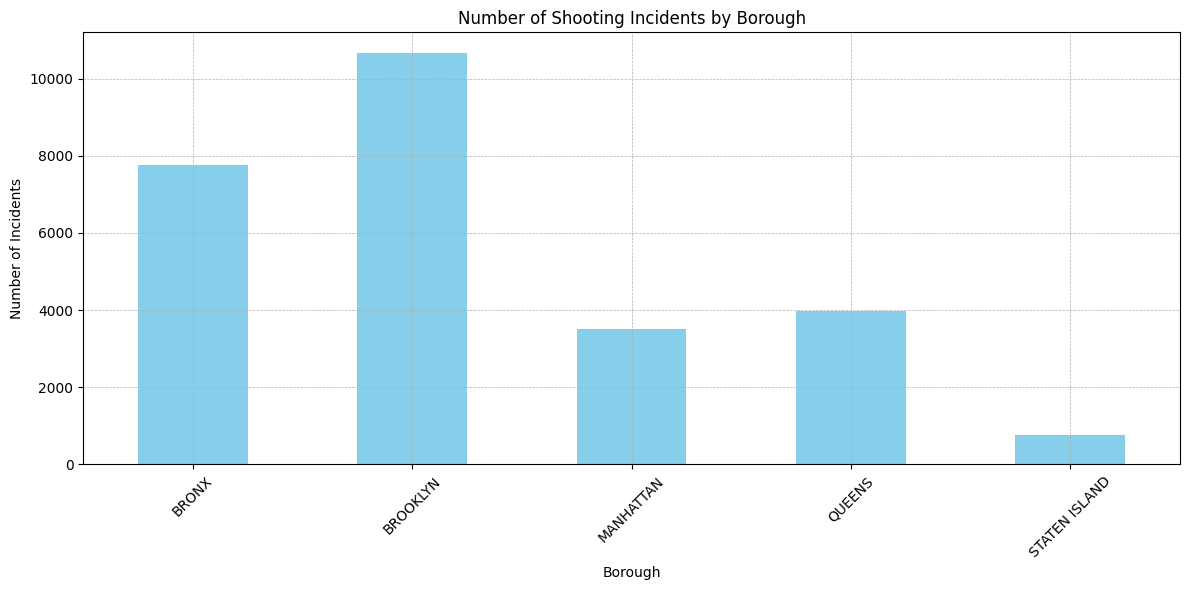

In [27]:
# Counting incidents per borough (BORO)
incidents_per_boro = cleaned_data['BORO'].value_counts().sort_index()

# Plotting the data
plt.figure(figsize=(12, 6))
incidents_per_boro.plot(kind='bar', color='skyblue')
plt.title('Number of Shooting Incidents by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Incidents')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)  # Rotating for better label visibility
plt.tight_layout()
plt.show()

#### Number of Shooting Incidents by Borough

- **Purpose:**  
  - Bar plot comparing shooting incidents across the five boroughs (2006-2024).

- **Trends Identified:**  
  - Brooklyn and the Bronx report the highest number of incidents, indicating possible hotspots.
  - Manhattan, Queens, and Staten Island have fewer incidents comparatively.

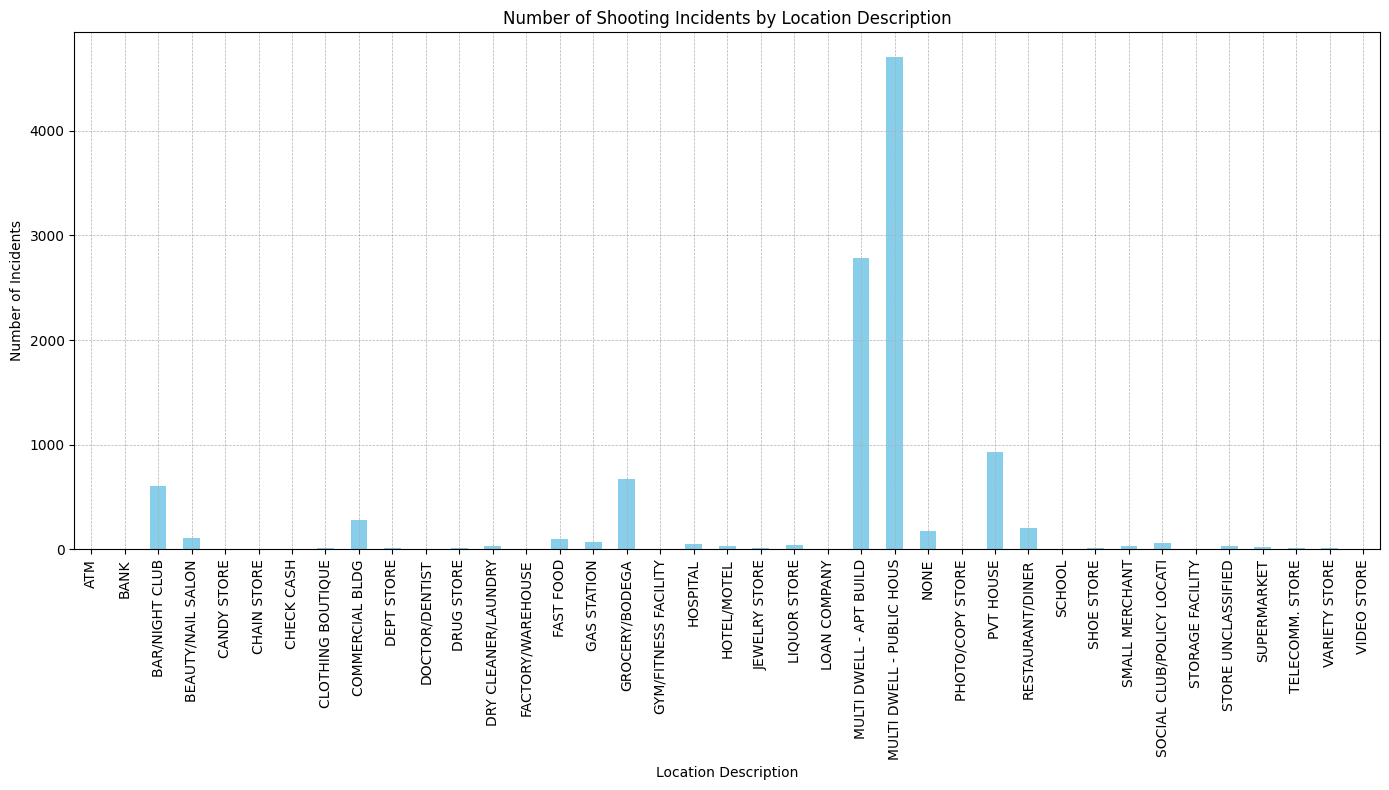

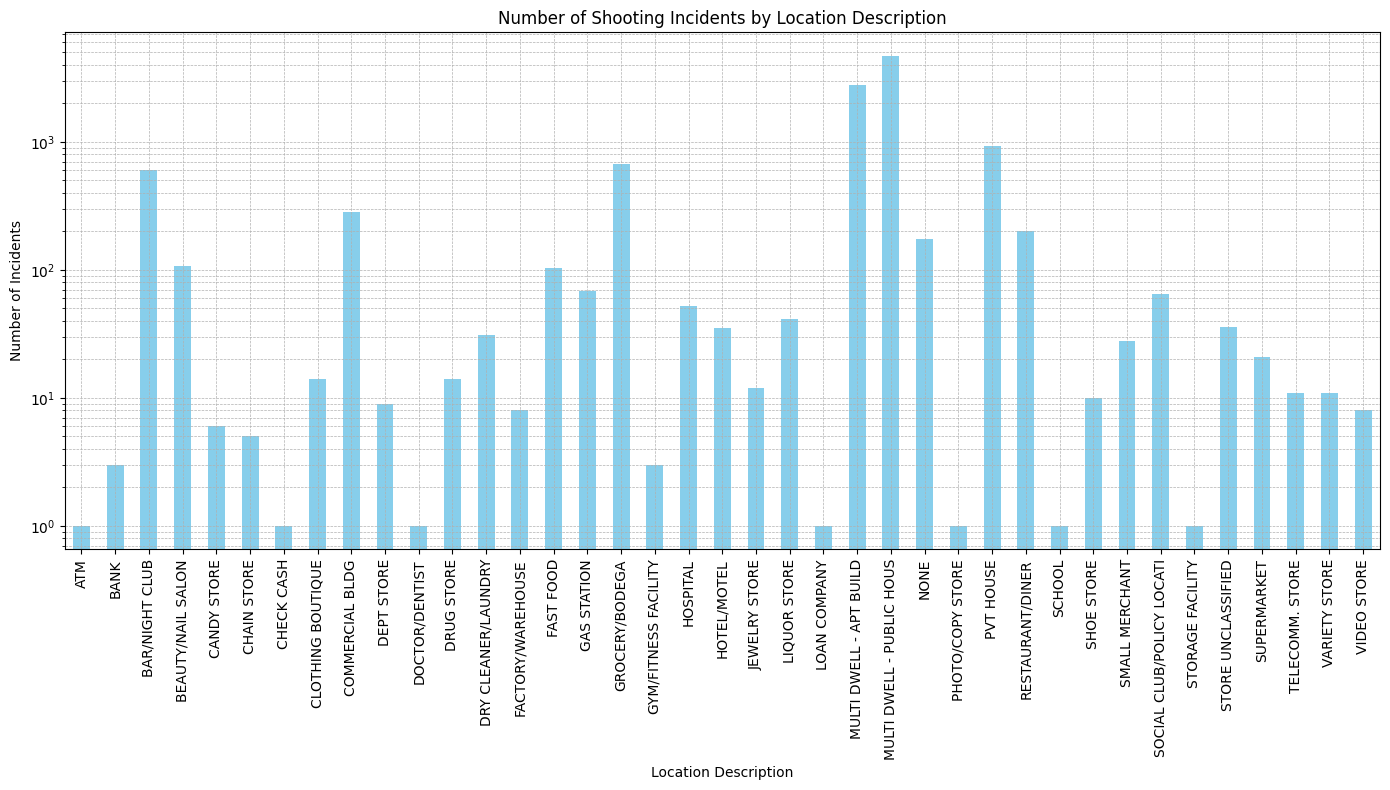

In [28]:
cleaned_data = cleaned_data[cleaned_data['LOCATION_DESC'] != '(null)']
filtered_location_desc = cleaned_data['LOCATION_DESC'].dropna()
incidents_per_location_desc = filtered_location_desc.value_counts().sort_index()

plt.figure(figsize=(14, 8))
incidents_per_location_desc.plot(kind='bar', color='skyblue')
plt.title('Number of Shooting Incidents by Location Description')
plt.xlabel('Location Description')
plt.ylabel('Number of Incidents')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=90)  # Rotating the labels for better readability
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
incidents_per_location_desc.plot(kind='bar', color='skyblue')
plt.title('Number of Shooting Incidents by Location Description')
plt.xlabel('Location Description')
plt.ylabel('Number of Incidents')
plt.yscale('log')  # Applying a logarithmic scale
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Number of Shooting Incidents by Location Description

- **Purpose:**  
  - Bar plot categorizing incidents by location type (2006-2024).

- **Trends Identified:**  
  - High occurrence at bars, gas stations, liquor stores, and nightclubs.
  - Lower incidents at banks, schools, and multi-dwelling houses.

- **Contextual Observations:**  
  - Social interaction and alcohol presence may increase shooting risks in venues like bars.
  - The prevalence of shootings on "Street" indicates pervasive urban gun violence beyond controlled environments.

In [36]:
# Group data by perpetrator age group and count incidents
incidents_per_perp_age_group = cleaned_data['PERP_AGE_GROUP'].value_counts().sort_index()

# Group data by victim age group and count incidents
incidents_per_vic_age_group = cleaned_data['VIC_AGE_GROUP'].value_counts().sort_index()

# Count incidents by perpetrator sex
incidents_per_perp_sex = cleaned_data['PERP_SEX'].value_counts().sort_index()

# Count incidents by victim sex
incidents_per_vic_sex = cleaned_data['VIC_SEX'].value_counts().sort_index()

# Assuming data loading and cleaning has already been done and 'data' is the DataFrame
# Count incidents by perpetrator race
incidents_per_perp_race = cleaned_data['PERP_RACE'].value_counts().sort_index()

# Count incidents by victim race
incidents_per_vic_race = cleaned_data['VIC_RACE'].value_counts().sort_index()


In [37]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming the necessary data preparation steps have been completed for age_group, sex, and race

# Create subplots
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=("Number of Shooting Incidents by Perpetrator and Victim Age Group",
                    "Number of Shooting Incidents by Sex",
                    "Number of Shooting Incidents by Race")
)

# Add first subplot for age group
fig.add_trace(
    go.Bar(name='Perpetrator Age Group', x=incidents_per_perp_age_group.index, y=incidents_per_perp_age_group.values, marker_color='rgb(255, 99, 71)'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(name='Victim Age Group', x=incidents_per_vic_age_group.index, y=incidents_per_vic_age_group.values, marker_color='rgb(100, 149, 237)'),
    row=1, col=1
)

# Add second subplot for sex
fig.add_trace(
    go.Bar(name='Perpetrator Sex', x=incidents_per_perp_sex.index, y=incidents_per_perp_sex.values, marker_color='rgb(255, 99, 71)'),
    row=2, col=1
)
fig.add_trace(
    go.Bar(name='Victim Sex', x=incidents_per_vic_sex.index, y=incidents_per_vic_sex.values, marker_color='rgb(100, 149, 237)'),
    row=2, col=1
)

# Add third subplot for race
fig.add_trace(
    go.Bar(name='Perpetrator Race', x=incidents_per_perp_race.index, y=incidents_per_perp_race.values, marker_color='rgb(255, 99, 71)'),
    row=3, col=1
)
fig.add_trace(
    go.Bar(name='Victim Race', x=incidents_per_vic_race.index, y=incidents_per_vic_race.values, marker_color='rgb(100, 149, 237)'),
    row=3, col=1
)

# Update layout for a cohesive look
fig.update_layout(
    title='Comprehensive Analysis of Shooting Incidents',
    barmode='group',
    height=1200,  # Adjust height to fit all plots comfortably
    showlegend=True,
    legend_title="Category",
    plot_bgcolor='rgba(0,0,0,0)'
)

# Update x-axis and y-axis titles individually if needed
fig.update_xaxes(title_text="Age Group", row=1, col=1)
fig.update_xaxes(title_text="Sex", row=2, col=1)
fig.update_xaxes(title_text="Race", row=3, col=1)
fig.update_yaxes(title_text="Number of Incidents", row=1, col=1)
fig.update_yaxes(title_text="Number of Incidents", row=2, col=1)
fig.update_yaxes(title_text="Number of Incidents", row=3, col=1)

# Show the plot
fig.show()

# Optionally, save the figure to HTML to be opened in any web browser
fig.write_html('Comprehensive_Shooting_Incidents_Analysis.html')  # Update the save path


#### Analysis of Demographic Data in Shooting Incidents

- **Purpose:**  
  - Series of bar plots breaking down incidents by age, sex, and race of perpetrators and victims.

- **Key Findings:**  
  - **Age Group:**  
    - Significant concentration in the 18-44 age range for both perpetrators and victims.
    - Marked decline in involvement above age 45.

  - **Sex:**  
    - Males are significantly more affected than females, highlighting a strong gender disparity.

  - **Race:**  
    - Black individuals are the most involved, followed by Hispanic individuals, indicating possible socio-economic factors.


The noticeable increase in shooting incidents during 2020 and 2021 called for careful analysis to identify patterns and contributing factors. Because of potential inaccuracies due to high missing data in columns like age, perpetrator race, sex, location and incident description these factors were set aside. Instead, we focused on the yearly incidents, different map plot and race to spot clear trends. Comparing data from 2020 and 2021 to earlier and later years showed the spike clearly, with 2020 reaching the highest number of incidents in recent years. 

An analysis of victim race each year showed that while overall shootings have gone down, the distribution across racial groups remained largely unchanged. 

The heatmap of race-on-race crime percentages showed that most incidents happened between people of the same race, with "Black-on-Black" crimes being the most frequent. The increase in shootings in 2020 and 2021 was unusual but consistent across different groups, suggesting widespread underlying issues. Although the overall decline in shootings is encouraging, the uneven impact on certain racial groups remains a concern. Understanding these trends will help shape focused policies and allocate resources for violence prevention and support programs.

In [38]:
# Convert 'OCCUR_DATE' to datetime if it's not already
cleaned_data['OCCUR_DATE'] = pd.to_datetime(cleaned_data['OCCUR_DATE'])


# Extract year and month
cleaned_data['YEAR'] = cleaned_data['OCCUR_DATE'].dt.year
cleaned_data['MONTH'] = cleaned_data['OCCUR_DATE'].dt.month

# Group by year and month and count the occurrences
monthly_crime_data = cleaned_data.groupby(['YEAR', 'MONTH']).size().reset_index(name='INCIDENTS')


# keep only last 5 years
monthly_crime_data = monthly_crime_data[monthly_crime_data['YEAR'] >=2018]

# Calculate maximum incidents per year for color scaling
max_incidents_per_year = monthly_crime_data.groupby('YEAR')['INCIDENTS'].max()

# Normalize these values to a 0-1 range for color mapping, set a minimum opacity
min_opacity = 0.2  # Adjust minimum opacity here
norm = (max_incidents_per_year - max_incidents_per_year.min()) / (max_incidents_per_year.max() - max_incidents_per_year.min()) * (1 - min_opacity) + min_opacity

# Map these normalized values back to the main DataFrame
monthly_crime_data['COLOR'] = monthly_crime_data['YEAR'].map(norm)

# Make sure we have enough colors for the number of years, repeat if needed
unique_years = monthly_crime_data['YEAR'].unique()
if len(discrete_colorscale) < len(unique_years):
    num_repeats = -(-len(unique_years) // len(discrete_colorscale))  # Ceiling division
    discrete_colorscale = (discrete_colorscale * num_repeats)[:len(unique_years)]

# Map years to colors
# year_to_color = {year: color for year, color in zip(unique_years, discrete_colorscale)}
# year_to_color[2020] = emphasis_color  # Assign the emphasis color to 2020

# Create the plot using Graph Objects for more control
fig = go.Figure()

# Add each year as a separate trace
for year in unique_years:
    year_data = monthly_crime_data[monthly_crime_data['YEAR'] == year]
    fig.add_trace(go.Scatter(
        x=year_data['MONTH'], 
        y=year_data['INCIDENTS'], 
        mode='lines',
        name=str(year),
        line=dict(color=year_to_color[year])  # Apply color based on the year
    ))

# Update the layout to add customizations
fig.update_layout(
    title='Monthly Shooting Incidents by Year',
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        gridcolor='gray',
    ),
    yaxis=dict(
        title='Number of Incidents',
        gridcolor='gray',
    ),
    legend_title_text='Year',
    plot_bgcolor='black',  # Set the plotting area background to black
    paper_bgcolor='black',  # Set the entire chart background to black
    font=dict(
        color='white'  # Ensure all default text (like legend, annotations) is white
    )
    # margin=dict(l=30, r=20, t=60, b=20)
)

fig.show()
pio.write_html(fig, file='monthly_shootings_per_year.html', auto_open=False)




In [39]:
discrete_colorscale = [
    'rgb(143,188,143)',  # Sea green
    'rgb(119,136,153)',  # Light slate gray
    'rgb(192,192,192)',  # Silver
    'rgb(47,79,79)',     # Dark slate gray
    'rgb(105,105,105)',  # Dim gray
    'rgb(255,165,0)'     # Orange for emphasis
]

# Replace 'nan' and any other identifier for unknown data with 'UNKNOWN'
cleaned_data['VIC_RACE'] = cleaned_data['VIC_RACE'].fillna('UNKNOWN').replace(['', ' ', 'N/A'], 'UNKNOWN')

# Group by year and victim race, count the occurrences
vic_race_yearly = cleaned_data.groupby(['YEAR', 'VIC_RACE']).size().unstack(fill_value=0)

# Combine 'UNKNOWN' and any other nan categories into one
vic_race_yearly['UNKNOWN'] = vic_race_yearly.get('UNKNOWN', 0) + vic_race_yearly.get('', 0)


# Calculate total incidents per year
total_incidents_per_year = vic_race_yearly.sum(axis=1)

# Calculate percentages
percentages = vic_race_yearly.divide(total_incidents_per_year, axis=0) * 100

# Assuming 'vic_race_yearly' and 'percentages' are already calculated as per your previous code

# Reset the index to turn 'YEAR' into a column and prepare data for plotting
vic_race_yearly_reset = vic_race_yearly.reset_index()
percentages_reset = percentages.reset_index()
percentages_reset = percentages_reset.round(0)

# Melt the data to long format, which Plotly can use to plot stacked area charts
vic_race_yearly_melted = vic_race_yearly_reset.melt(id_vars='YEAR', var_name='Victim Race', value_name='Number of Incidents')
percentages_melted = percentages_reset.melt(id_vars='YEAR', var_name='Victim Race', value_name='Percentage')

# Merge the counts and percentages into a single DataFrame
area_chart_data = vic_race_yearly_melted.merge(percentages_melted, on=['YEAR', 'Victim Race'])
# Filter out 'UNKNOWN' from visualization, not from calculation
area_chart_data = area_chart_data[area_chart_data['Victim Race'] != 'UNKNOWN']
area_chart_data.sort_values(by=['YEAR', 'Percentage'], inplace=True)


# Create a stacked area chart with hover data showing percentages
# Assuming you know the races involved or you extract them from the DataFrame
races = area_chart_data['Victim Race'].unique()
color_map = {race: color for race, color in zip(races, discrete_colorscale)}

# Apply the discrete color palette to the area chart
fig_area = px.area(area_chart_data, x='YEAR', y='Number of Incidents', color='Victim Race',
                   title="Victim Race Distribution by Year",
                   labels={'YEAR': 'Year', 'Number of Incidents': 'Number of Incidents', 'Victim Race': 'Victim Race'},
                   hover_data={'Number of Incidents': True, 'Percentage': True},
                   color_discrete_map=color_map)  # Using the color mapping

# Update layout
fig_area.update_layout(
    xaxis=dict(
        title='Year',
        gridcolor='gray',
    ),
    yaxis=dict(
        title='Number of Incidents',
        gridcolor='gray',
    ),
    legend_title_text='Victim Race',
    plot_bgcolor='black',  # Set the plotting area background to black
    paper_bgcolor='black',  # Set the entire chart background to black
    font=dict(
        color='white'  # Ensure all default text (like legend, annotations) is white
    )
)

fig_area.show()
pio.write_html(fig, file='victim_race_distribution.html', auto_open=False)


In [40]:
# Filter out unknown and nan races for perpetrators and victims
filtered_data = cleaned_data[
    (cleaned_data['PERP_RACE'].notna()) & (cleaned_data['PERP_RACE'] != 'UNKNOWN') &
    (cleaned_data['VIC_RACE'].notna()) & (cleaned_data['VIC_RACE'] != 'UNKNOWN') &
    (cleaned_data['VIC_RACE'] != 'AMERICAN INDIAN/ALASKAN NATIVE') &
    (cleaned_data['PERP_RACE'] != 'AMERICAN INDIAN/ALASKAN NATIVE')
]

# Create a crosstab of perpetrator and victim races
# Ensure PERP_RACE are rows and VIC_RACE are columns
race_on_race = pd.crosstab(filtered_data['PERP_RACE'], filtered_data['VIC_RACE'])

for i in range(0,5):
    s = race_on_race.iloc[i].sum(axis=0)
    race_on_race.iloc[i] = race_on_race.iloc[i]/s
    race_on_race.iloc[i] = (race_on_race.iloc[i] * 100).round(2)


# Plotting a density heatmap using the grayscale color scale
fig = px.imshow(
    race_on_race,
    labels=dict(x="Victim Race", y="Perpetrator Race", color="Incident Count"),
    title='Heatmap of Race-on-Race Crime Percentages',
    aspect='auto',  # Adjust the aspect ratio to auto if needed
    color_continuous_scale=continuous_colorscale  # Apply the continuous color scale
)

# Ensure axes labels are correct and on the appropriate side
fig.update_xaxes(side="bottom", tickmode='array', tickvals=list(range(len(race_on_race.columns))), ticktext=race_on_race.columns)
fig.update_yaxes(tickmode='array', tickvals=list(range(len(race_on_race.index))), ticktext=race_on_race.index)

# Optionally, you can add a color axis title
fig.update_layout(coloraxis_colorbar=dict(
    title="",  # Adding two line breaks for spacing
    titleside="top"
    ),
    plot_bgcolor='black',  # Set the plotting area background to black
    paper_bgcolor='black',  # Set the entire chart background to black
    font=dict(
        color='white'  # Ensure all default text (like legend, annotations) is white
    )
    
    )
fig.show()
pio.write_html(fig, file='confusion_matrix_interracial_shootings.html', auto_open=False)


/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_55239/967065366.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3129251700680272' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_55239/967065366.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.35374149659863946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/tx/m38yq8k57gs15658kl2q0c600000gn/T/ipykernel_55239/967065366.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08843537414965986' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/tx/m38yq8k57gs15658kl2q0c

To understand the significant spike in incidents during this period, we investigated further to uncover potential causes. We discovered that in May 2020, George Floyd was tragically killed by the police, triggering widespread protests across the United States. We believe these events, combined with the COVID-19 pandemic, significantly contributed to the increase in shootings, as crime rates rose across the board during this period. Additionally, it was a challenging time as it marked the beginning of the lockdowns.. To delve deeper, we examined the NYC_layoff_interest.csv dataset to see if there was any correlation between layoffs and the spike in incidents. While it's not the only factor, we noticed a clear upward trend from February to a peak in May, suggesting a combination of factors, including social unrest and economic stress from mass layoffs, may have contributed to this surge.

In [41]:
layoffs = pd.read_csv("NYC_layoff_interest.csv")
# Ensure the 'Week' column is datetime type
layoffs['Week'] = pd.to_datetime(layoffs['Week'])

# Extract the month from the 'Week' column
layoffs['Month'] = layoffs['Week'].dt.month

monthly_layoffs = layoffs.groupby('Month')['Layoff Google Searches in New York'].sum().reset_index()

max_val = monthly_layoffs['Layoff Google Searches in New York'].max()
monthly_layoffs['Layoff Google Interest in New York for 2020'] = monthly_layoffs['Layoff Google Searches in New York'] * 100/max_val


# Create the line graph with Plotly Express
fig = px.line(
    monthly_layoffs, 
    x='Month', 
    y='Layoff Google Interest in New York for 2020', 
    title='Monthly Layoff Interest in New York for 2020',
    labels={'Month': 'Month', 'Layoff Google Interest in New York for 2020': 'Layoffs Interest'},
    color_discrete_sequence=['green']
)

# Add layout customization
fig.update_layout(
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
         gridcolor='gray',
    ),
    yaxis=dict(
        title='Layoffs',
        gridcolor='gray',
    ),
    plot_bgcolor='black',  # Set the plotting area background to black
    paper_bgcolor='black',  # Set the entire chart background to black
    font=dict(
        color='white'  # Ensure all default text (like legend, annotations) is white
    )
)

fig.show()
pio.write_html(fig, file='monthly_layoffs.html', auto_open=False)

